The code presented here is a good way to learn about logistic regression. The purpose here is to show how logistic regression works. This is not for mass production. The estimates from sklearn are oging to be faster and more accurate. You can get closer to the sklearn results by adjusting the learning rate and maximum iteration paramters. This is also a good example of employing the gradient descent method for optimizing the log-likelihood function of the logistic regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore") # I don't recommend doing this, I am using this to keep the notebook cleaner.

Let's create some data first. Later, I am going to simulate the data in another way that would seem more intutive for using logistic regression. I am creating the feature variable in two steps. First a latent style variable depending on the attributes directly. Second, the actual features depending on these latent y values.

In [2]:
m=200 # number of observation
x1=stats.norm(20, 5).rvs(m)
x2=stats.norm(40, 5).rvs(m)
ylat=[7+0.5*a+0.7*b+stats.norm(0, 5).rvs(1) for a, b in zip(x1, x2)] # going to use these values to get the features

In [3]:
y=np.zeros((m, 1))
c=0
for i in range(m):
    if ylat[i]>45:
        y[i]=1
        c=c+1
# these are the features.
print("total observations :", m) 
print("total number of values coded 1 is :", c) # this is the number of 1's in the sample

total observations : 200
total number of values coded 1 is : 95


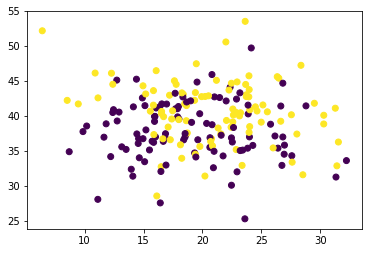

In [4]:
plt.scatter(x1, x2, c=y)
plt.show() #this is the baseline, take a look at this again after the estimation procedure.

I am not going to split into train and test sets as my objective here is to demonstrate how the method works.

In [5]:
x0=np.ones((m, 1))
X=np.column_stack((x0, x1, x2))
logistreg=LogisticRegression(fit_intercept=False)
logistreg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
logistreg.coef_

array([[-2.48706536,  0.03636936,  0.04365357]])

In [7]:
logistreg.score(X, y) # model performance

0.655

In [8]:
class logistregression:
    
    '''this is a class to estimate logistic regression.
    takes the independent variable and the dependent variables to instantiate.
    the independent variables should include the intercept term.'''
    
    def __init__(self, depvar, indepvar):
        self.y=depvar
        self.X=indepvar
        self.m=len(depvar)
        self.k=indepvar.shape[1]
        
    def sigmoidfunction(self, z):
        return 1/(1+np.exp(-z))
    
    def negativelikelihood_2(theta):
        '''this is one way of writing the objective function.
        The code is not vectorized, so not efficient. but it is helpful to
        understand the mechanism.'''
        
        s0=0
        for i in range(len(self.y)):
            if self.y[i]==1:
                s0=s0+np.log(self.sigmoidfunction(xb[i])) #cost of prediction when y=1
            if self.y[i]==0:
                s0=s0+np.log(1-(self.sigmoidfunction(xb[i]))) #cost of prediction when y=0
        
        return -np.sum(s0) #total cost, this is the objective function we want to minimize

        
    
    def neglikelihoodfunc(self, theta):
        '''returns the negative of the loglikelihood function'''
        
        xb=self.X@theta
        
               
        s=np.asarray(y).T@np.log(self.sigmoidfunction(xb))+np.asarray(np.ones((self.m, 1))-y).T@np.log(1-(self.sigmoidfunction(xb)))
                       
        return -np.sum(s)
    
    def getparam(self, method='Nelder-Mead'):
        '''returns the parameters by optimizing the objective function as per the method parameter'''
        initbeta=np.random.rand(self.k, 1)
        result=minimize(self.neglikelihoodfunc, initbeta, method=method)
        return result.x
    
    def getparam2(self, maxiter=10000, lrate=0.0001, tolerance=0.001):
        '''returns the parameters by optimizing the objective function using gradient descent'''
        #thetaold=np.random.rand(self.k, 1)
        thetaold=np.asarray(np.linalg.inv(self.X.T@self.X)@self.X.T@self.y).reshape(self.k, 1)
        thetaprev=thetaold+2
        iterator=1
        y=np.asarray(self.y).reshape((self.m, 1))
        d=maxiter/10
        while iterator<=maxiter: #  or all(abs(told-tprev)>tolerance for told, tprev in zip(thetaold, thetaprev))
            xb=self.X@thetaold
            thetanew=thetaold+np.asarray((self.X.T@(y-self.sigmoidfunction(xb))))*lrate
            #if iterator==1:
                #print("neg loglikelihood at first iteration :", self.neglikelihoodfunc(thetaold), "parameters are :", thetaold, "\n parameters became :", thetanew)
            if iterator%d==0:
                print("value of negative log likelihood was :", self.neglikelihoodfunc(thetanew), 
                      "\nafter iteration number :", iterator)
                #print("iteration started with :", thetaold, "ended with :", thetanew)
                lrate=lrate/iterator
            thetaold=thetanew
            thetaprev=thetaold
            iterator=iterator+1
        print()
        print("number of iterations :", iterator-1) 
        print()
        return thetanew
    
    def predict_score(self):
        '''returns the percentage of cases correctly classified.'''
        xbhat=self.X@self.getparam()
        ylathat=[1/(1+np.exp(-x)) for x in xbhat]
        yhat=[]
        for i in range(len(ylathat)):
            if ylathat[i]>=0.5:
                yhat.append(1)
            else:
                yhat.append(0)
                
        n=len(self.y)
        s=0
        for i in range(len(self.y)):
            if self.y[i]==yhat[i]:
                s=s+1
            else:
                s=s
                
        return s/n
    
    
    def get_yhat(cls):
        '''returns the predicted labels'''
        xbhat=X@cls.getparam2()
        ylathat=[1/(1+np.exp(-x)) for x in xbhat]
        yhat=[]
        for i in range(len(ylathat)):
            if ylathat[i]>=0.5:
                yhat.append(1)
            else:
                yhat.append(0)
                
        return yhat


        
    

In [9]:
cls=logistregression(y, X)

In [10]:
cls.predict_score()

0.475

In [11]:
cls.getparam2() 
#can improve these estimates by adjusting the learning rate and tolerance to get close to sklearn estimated values
# see the printed out number of iterations that were ran.

value of negative log likelihood was : 822.0653835068348 
after iteration number : 1000
value of negative log likelihood was : 265.5331225288735 
after iteration number : 2000
value of negative log likelihood was : 265.52663291804873 
after iteration number : 3000
value of negative log likelihood was : 265.52663075575333 
after iteration number : 4000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 5000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 6000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 7000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 8000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 9000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 10000

number of iterations : 10000



array([[-1.69766272],
       [ 0.56451304],
       [-0.2387872 ]])

In [12]:
cls.getparam(method='BFGS') #another method

array([0.05494451, 0.60776732, 0.96926867])

In [13]:
cls.getparam() #default Nelder-Mead

array([0.48839224, 0.1555344 , 0.98168156])

In [14]:
yhat=cls.get_yhat()

value of negative log likelihood was : 822.0653835068348 
after iteration number : 1000
value of negative log likelihood was : 265.5331225288735 
after iteration number : 2000
value of negative log likelihood was : 265.52663291804873 
after iteration number : 3000
value of negative log likelihood was : 265.52663075575333 
after iteration number : 4000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 5000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 6000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 7000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 8000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 9000
value of negative log likelihood was : 265.52663075519365 
after iteration number : 10000

number of iterations : 10000



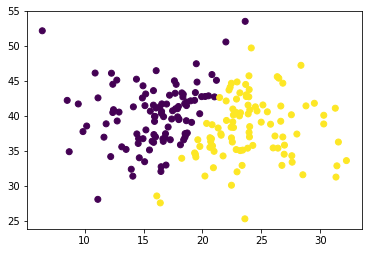

In [15]:
plt.scatter(x1, x2, c=yhat)
plt.show() # compare this figure with the previous one. There is definitely scope of improvement.

Now, let's try to simulate the data in more of an appealing way for logistic regression.


In [16]:
m=1000
x0=np.ones((m, 1))
x1=stats.norm(10, 3).rvs(m)
x2=stats.norm(30, 5).rvs(m)
x3=stats.poisson(20).rvs(m)
X=np.column_stack((x0, x1, x2, x3))
btrue=[-2, 5, -1, -1]
Xbtrue=X@btrue+stats.norm(0, 5).rvs(m)
def sigfunc(z):
    return 1/(1+np.exp(-z))
ylat=[1/(1+np.exp(-z)) for z in Xbtrue]
y=[]
c1=0
for i in range(len(ylat)):
    if ylat[i]>=0.5:
        y.append(1)
        c1=c1+1
    else:
        y.append(0)

y=np.asarray(y)
#this data simulation is faster than the previous case

In [17]:
print("total 1 coded observation :", c1, "out of total observation of :", m)

total 1 coded observation : 460 out of total observation of : 1000


In [18]:
cls1=logistregression(y, X)

In [19]:
cls1.getparam() #Nelder-mead

array([0.63704983, 0.70713003, 0.86799263, 0.86217539])

In [20]:
cls1.getparam(method='BFGS')

array([0.03565373, 0.31015901, 0.96365253, 0.35437641])

In [22]:
cls1.getparam2(maxiter=1000000, lrate=0.00001) #gradient descent
# need to play with the lrate parameter as high lrate makes the negloglikelihood a nan

value of negative log likelihood was : 1307426.283997403 
after iteration number : 100000
value of negative log likelihood was : 1307426.2659189398 
after iteration number : 200000
value of negative log likelihood was : 1307426.2659108916 
after iteration number : 300000
value of negative log likelihood was : 1307426.2659108916 
after iteration number : 400000
value of negative log likelihood was : 1307426.2659108916 
after iteration number : 500000
value of negative log likelihood was : 1307426.2659108916 
after iteration number : 600000
value of negative log likelihood was : 1307426.2659108916 
after iteration number : 700000
value of negative log likelihood was : 1307426.2659108916 
after iteration number : 800000
value of negative log likelihood was : 1307426.2659108916 
after iteration number : 900000
value of negative log likelihood was : 1307426.2659108916 
after iteration number : 1000000

number of iterations : 1000000



array([[-0.95943407],
       [ 1.82619465],
       [-0.37858361],
       [-0.32381965]])

In [23]:
# on the other hand, using sklearn-
logistreg1=LogisticRegression(fit_intercept=False)
logistreg1.fit(X, y)
logistreg1.coef_ 
# these coeffs are not going to be same as the coefficients we got from my code. 
# the sklearn code is optimized to produce better results faster
# the objective of my code is to show the mechanism behind the logistic regression only.
# yet, these numbers are pretty close

array([[-0.87716947,  1.7910699 , -0.37248849, -0.31904095]])